<a href="https://colab.research.google.com/github/TipsyPanda/ComplexBridges/blob/main/BridgeDataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

In [4]:
# Read in the dataset
url = "https://github.com/TipsyPanda/ComplexBridges/raw/main/ipmb_5sensors_30min_1_to_10hz.csv"
bridgeData = pd.read_csv(url)

In [9]:
bridgeData.head()

,timestamp,bridge_id,span_id,sensor_id,sensor_type,value,unit,traffic_load_proxy,rule_threshold,anomaly,anomaly_type
0,2025-10-10T12:00:00,BRIDGE_A01,SPAN_1,SG_001,strain_gauge,118.571847,microstrain,0.5,200.00,0,NaN
1,2025-10-10T12:00:00,BRIDGE_A01,SPAN_2,SG_002,strain_gauge,128.986727,microstrain,0.5,200.00,0,NaN
2,2025-10-10T12:00:00,BRIDGE_A01,SPAN_1,ACC_101,accelerometer_rms,0.020849,g,0.5,0.05,0,NaN
3,2025-10-10T12:00:00,BRIDGE_A01,SPAN_2,ACC_102,accelerometer_rms,0.015481,g,0.5,0.05,0,NaN
4,2025-10-10T12:00:00,BRIDGE_A01,SPAN_2,TMP_201,temperature,21.884280,C,0.5,35.00,0,NaN


In [6]:
bridgeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           90000 non-null  object 
 1   bridge_id           90000 non-null  object 
 2   span_id             90000 non-null  object 
 3   sensor_id           90000 non-null  object 
 4   sensor_type         90000 non-null  object 
 5   value               90000 non-null  float64
 6   unit                90000 non-null  object 
 7   traffic_load_proxy  90000 non-null  float64
 8   rule_threshold      90000 non-null  float64
 9   anomaly             90000 non-null  int64  
 10  anomaly_type        3852 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 7.6+ MB


In [7]:
bridgeData.isna().sum()
#only empty values in anomaly type since it only shows if there is an anomaly

,0
timestamp,0
bridge_id,0
span_id,0
sensor_id,0
sensor_type,0
value,0
unit,0
traffic_load_proxy,0
rule_threshold,0
anomaly,0


In [8]:
# Print description of DataFrame
bridgeData.describe()

,value,traffic_load_proxy,rule_threshold,anomaly
count,90000.000000,90000.000000,90000.000000,90000.000000
mean,60.327781,0.500000,87.020000,0.042800
std,68.617340,0.353593,93.126886,0.202407
min,0.004077,0.000000,0.050000,0.000000
25%,0.021788,0.146000,0.050000,0.000000
50%,22.029184,0.500000,35.000000,0.000000
75%,123.721347,0.854000,200.000000,0.000000
max,286.421924,1.000000,200.000000,1.000000


In [16]:
bridgeData['timestamp'] = pd.to_datetime(bridgeData['timestamp'], format='ISO8601')
bridgeData.set_index('timestamp', inplace=True)


                      bridge_id span_id sensor_id        sensor_type  \
timestamp                                                              
2025-10-10 12:00:00  BRIDGE_A01  SPAN_1    SG_001       strain_gauge   
2025-10-10 12:00:00  BRIDGE_A01  SPAN_2    SG_002       strain_gauge   
2025-10-10 12:00:00  BRIDGE_A01  SPAN_1   ACC_101  accelerometer_rms   
2025-10-10 12:00:00  BRIDGE_A01  SPAN_2   ACC_102  accelerometer_rms   
2025-10-10 12:00:00  BRIDGE_A01  SPAN_2   TMP_201        temperature   

                          value         unit  traffic_load_proxy  \
timestamp                                                          
2025-10-10 12:00:00  118.571847  microstrain                 0.5   
2025-10-10 12:00:00  128.986727  microstrain                 0.5   
2025-10-10 12:00:00    0.020849            g                 0.5   
2025-10-10 12:00:00    0.015481            g                 0.5   
2025-10-10 12:00:00   21.884280            C                 0.5   

                  

In [19]:
bridgeData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90000 entries, 2025-10-10 12:00:00 to 2025-10-10 12:29:59.900000
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bridge_id           90000 non-null  object 
 1   span_id             90000 non-null  object 
 2   sensor_id           90000 non-null  object 
 3   sensor_type         90000 non-null  object 
 4   value               90000 non-null  float64
 5   unit                90000 non-null  object 
 6   traffic_load_proxy  90000 non-null  float64
 7   rule_threshold      90000 non-null  float64
 8   anomaly             90000 non-null  int64  
 9   anomaly_type        3852 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 7.6+ MB


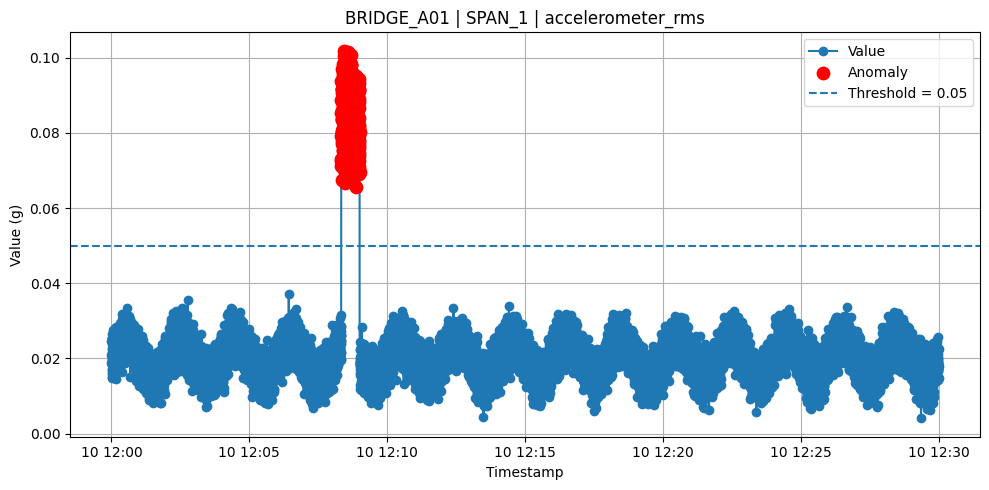

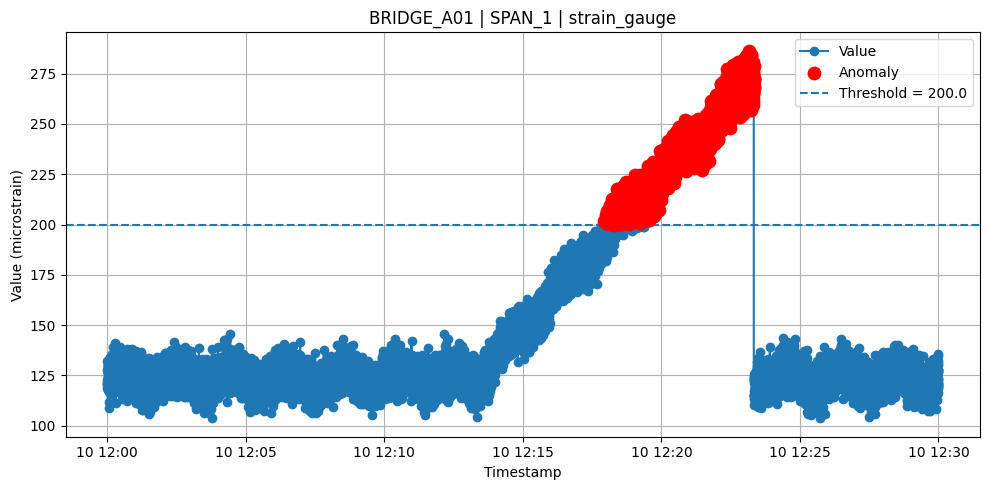

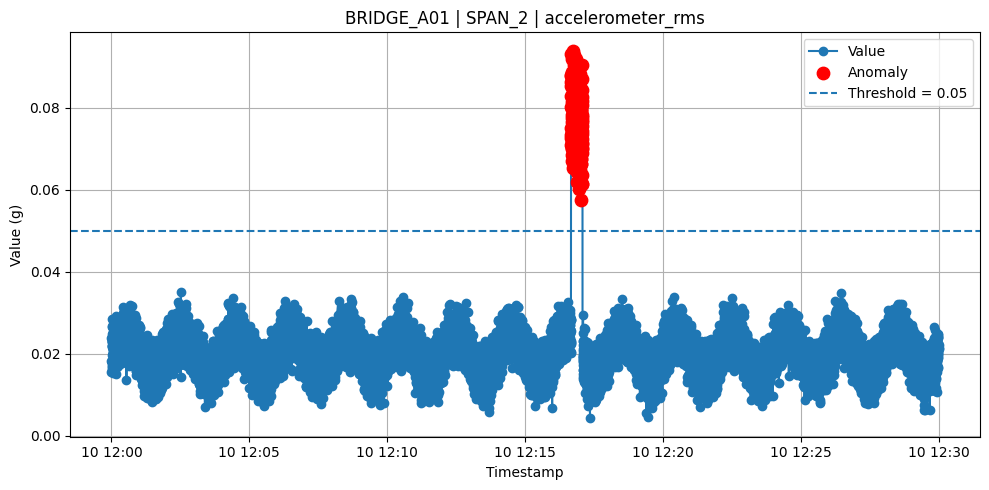

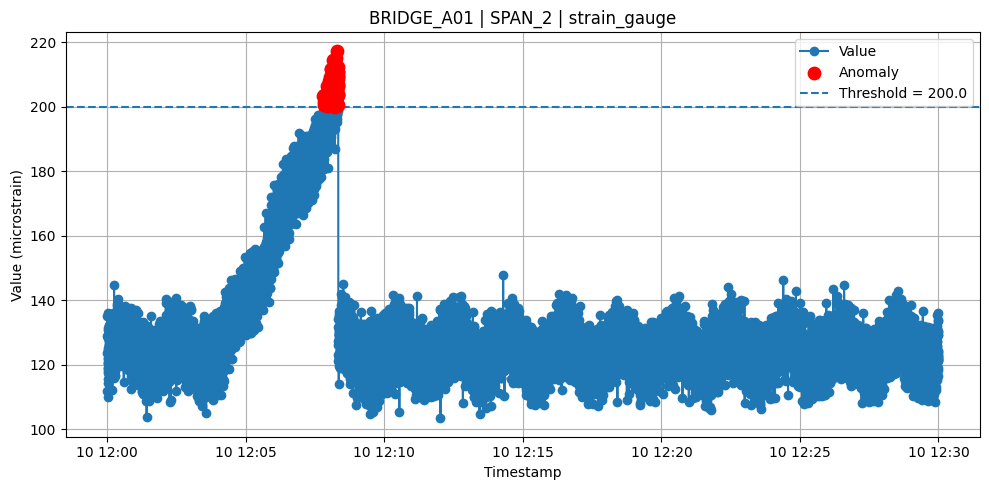

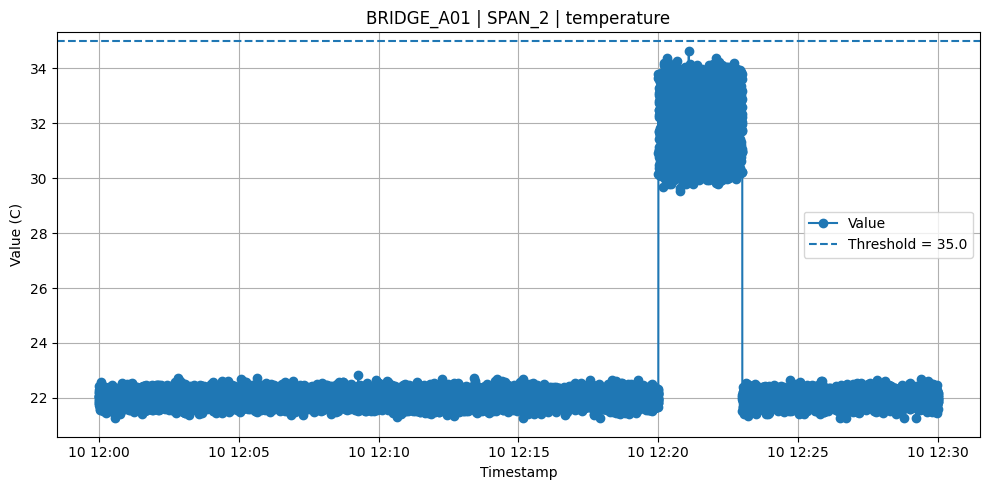

In [21]:
# Ensure anomaly is numeric (0/1)
bridgeData['anomaly'] = pd.to_numeric(bridgeData['anomaly'], errors='coerce').fillna(0).astype(int)

grouped = bridgeData.groupby(['bridge_id', 'span_id', 'sensor_type'])

for (bridge, span, sensor), group in grouped:
    group = group.sort_index()
    normal = group[group['anomaly'] == 0]
    anoms  = group[group['anomaly'] == 1]

    plt.figure(figsize=(10, 5))
    # main series
    plt.plot(group.index, group['value'], marker='o', label='Value')

    # anomalies in red
    if not anoms.empty:
        plt.scatter(anoms.index, anoms['value'], s=80, marker='o', label='Anomaly', c='red', zorder=3)

    # rule threshold (horizontal if constant; otherwise as a series)
    if group['rule_threshold'].nunique() == 1:
        thr = group['rule_threshold'].iloc[0]
        plt.axhline(thr, linestyle='--', linewidth=1.5, label=f'Threshold = {thr}')
    else:
        plt.plot(group.index, group['rule_threshold'], linestyle='--', linewidth=1.2, label='Threshold')

    plt.title(f"{bridge} | {span} | {sensor}")
    plt.xlabel("Timestamp")
    plt.ylabel(f"Value ({group['unit'].iloc[0]})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()